In [2]:
import cv2
import os

# 데이터 디렉토리 경로
base_directory = './data_gray'

# 사용할 카테고리 폴더 이름
category_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 
                  'metal', 'paper', 'plastic', 'shoes', 'trash']

# 결과를 저장할 폴더 경로 - Canny 연산 결과
canny_output_directory = './canny_edge_results'
if not os.path.exists(canny_output_directory):
    os.makedirs(canny_output_directory)

# 각 카테고리마다 모든 이미지에 Canny 연산 적용
for category_name in category_names:
    category_directory = os.path.join(base_directory, category_name)
    
    # Canny 연산 결과 저장 폴더
    canny_output_category_directory = os.path.join(canny_output_directory, category_name)
    if not os.path.exists(canny_output_category_directory):
        os.makedirs(canny_output_category_directory)
    
    file_list = os.listdir(category_directory)
    for file_name in file_list:
        image_path = os.path.join(category_directory, file_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Canny 연산 적용
        canny_edges = cv2.Canny(image, 100, 200)  # 임계값 100, 200 사용
        
        # 결과를 파일로 저장 - Canny 연산 결과
        canny_output_path = os.path.join(canny_output_category_directory, f'{file_name[:-4]}_canny_edge.jpg')
        cv2.imwrite(canny_output_path, canny_edges)
        print(f"Canny 연산 결과가 저장되었습니다: {canny_output_path}")


Canny 연산 결과가 저장되었습니다: ./canny_edge_results\battery\gray_resized_battery_1_canny_edge.jpg
Canny 연산 결과가 저장되었습니다: ./canny_edge_results\battery\gray_resized_battery_10_canny_edge.jpg
Canny 연산 결과가 저장되었습니다: ./canny_edge_results\battery\gray_resized_battery_100_canny_edge.jpg
Canny 연산 결과가 저장되었습니다: ./canny_edge_results\battery\gray_resized_battery_101_canny_edge.jpg
Canny 연산 결과가 저장되었습니다: ./canny_edge_results\battery\gray_resized_battery_102_canny_edge.jpg
Canny 연산 결과가 저장되었습니다: ./canny_edge_results\battery\gray_resized_battery_103_canny_edge.jpg
Canny 연산 결과가 저장되었습니다: ./canny_edge_results\battery\gray_resized_battery_104_canny_edge.jpg
Canny 연산 결과가 저장되었습니다: ./canny_edge_results\battery\gray_resized_battery_105_canny_edge.jpg
Canny 연산 결과가 저장되었습니다: ./canny_edge_results\battery\gray_resized_battery_106_canny_edge.jpg
Canny 연산 결과가 저장되었습니다: ./canny_edge_results\battery\gray_resized_battery_107_canny_edge.jpg
Canny 연산 결과가 저장되었습니다: ./canny_edge_results\battery\gray_resized_battery_108_canny_edge.jpg
Ca

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

data_dir = './canny_edge_results'
output_dir = './data_gray_split'
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Train, val 폴더 생성
os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'val'), exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(output_dir, 'train', cls), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'val', cls), exist_ok=True)
    
    class_dir = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
    
    for img in train_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'train', cls, img))
        
    for img in val_images:
        shutil.copy(os.path.join(class_dir, img), os.path.join(output_dir, 'val', cls, img))

print("Data splitting completed.")

Data splitting completed.


In [5]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# 데이터 전처리 및 로드
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # 그레이스케일로 변환
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # 그레이스케일 이미지는 평균과 표준편차를 [0.5]로 설정
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}

data_dir = './data_gray_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive Average Pooling
        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

num_classes = len(class_names)
model = SimpleCNN(num_classes).to(device)


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        print()

    return model

model = train_model(model, criterion, optimizer, num_epochs=10)


Epoch 0/9
----------
train Loss: 2.0740 Acc: 0.2633
val Loss: 2.0053 Acc: 0.2743

Epoch 1/9
----------
train Loss: 1.9486 Acc: 0.3044
val Loss: 1.8633 Acc: 0.3464

Epoch 2/9
----------
train Loss: 1.8446 Acc: 0.3496
val Loss: 1.7692 Acc: 0.3776

Epoch 3/9
----------
train Loss: 1.7664 Acc: 0.3845
val Loss: 1.6589 Acc: 0.4336

Epoch 4/9
----------
train Loss: 1.6876 Acc: 0.4209
val Loss: 1.5887 Acc: 0.4556

Epoch 5/9
----------
train Loss: 1.6170 Acc: 0.4467
val Loss: 1.5394 Acc: 0.4744

Epoch 6/9
----------
train Loss: 1.5744 Acc: 0.4650
val Loss: 1.5307 Acc: 0.4658

Epoch 7/9
----------
train Loss: 1.5245 Acc: 0.4757
val Loss: 1.4304 Acc: 0.5129

Epoch 8/9
----------
train Loss: 1.4843 Acc: 0.4926
val Loss: 1.3989 Acc: 0.5325

Epoch 9/9
----------
train Loss: 1.4468 Acc: 0.5082
val Loss: 1.3815 Acc: 0.5304



In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        print()

    return model

model = train_model(model, criterion, optimizer, num_epochs=20)


Epoch 0/19
----------
train Loss: 1.4135 Acc: 0.5208
val Loss: 1.3374 Acc: 0.5433

Epoch 1/19
----------
train Loss: 1.3806 Acc: 0.5300
val Loss: 1.2959 Acc: 0.5596

Epoch 2/19
----------
train Loss: 1.3494 Acc: 0.5423
val Loss: 1.2935 Acc: 0.5664

Epoch 3/19
----------
train Loss: 1.3146 Acc: 0.5505
val Loss: 1.2522 Acc: 0.5716

Epoch 4/19
----------
train Loss: 1.2925 Acc: 0.5574
val Loss: 1.2482 Acc: 0.5773

Epoch 5/19
----------
train Loss: 1.2672 Acc: 0.5660
val Loss: 1.1993 Acc: 0.5970

Epoch 6/19
----------
train Loss: 1.2430 Acc: 0.5748
val Loss: 1.2348 Acc: 0.5733

Epoch 7/19
----------
train Loss: 1.2194 Acc: 0.5836
val Loss: 1.2198 Acc: 0.5759

Epoch 8/19
----------
train Loss: 1.1984 Acc: 0.5916
val Loss: 1.1804 Acc: 0.6025

Epoch 9/19
----------
train Loss: 1.1784 Acc: 0.6031
val Loss: 1.1176 Acc: 0.6230

Epoch 10/19
----------
train Loss: 1.1549 Acc: 0.6081
val Loss: 1.1349 Acc: 0.6105

Epoch 11/19
----------
train Loss: 1.1353 Acc: 0.6116
val Loss: 1.1094 Acc: 0.6173

Ep

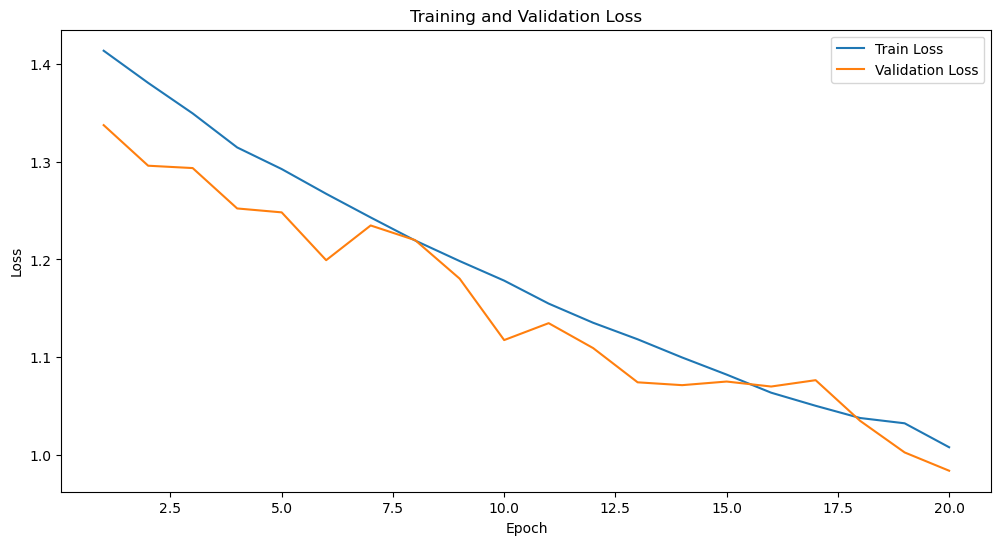

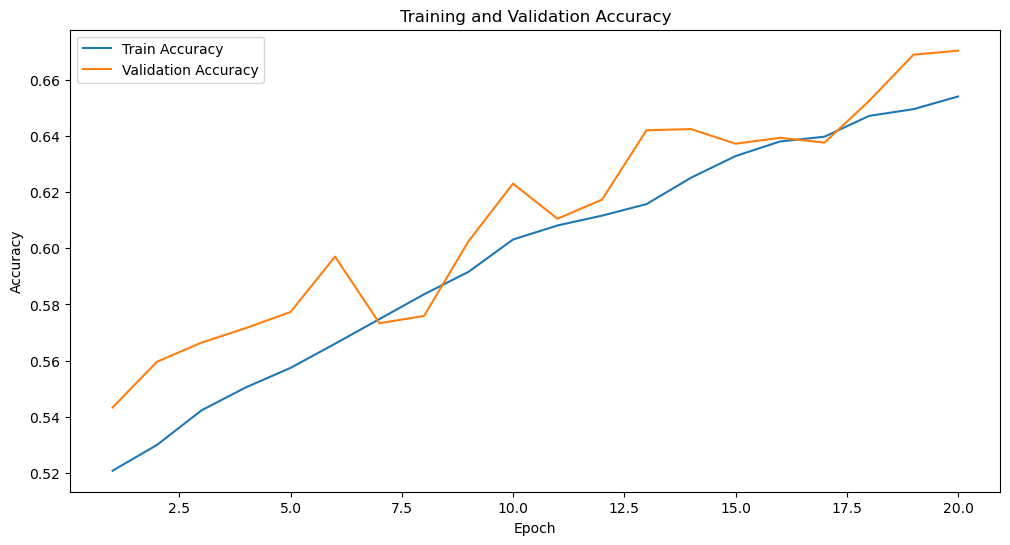

In [10]:
import re
import matplotlib.pyplot as plt

log_text = """
Epoch 0/19
----------
train Loss: 1.4135 Acc: 0.5208
val Loss: 1.3374 Acc: 0.5433

Epoch 1/19
----------
train Loss: 1.3806 Acc: 0.5300
val Loss: 1.2959 Acc: 0.5596

Epoch 2/19
----------
train Loss: 1.3494 Acc: 0.5423
val Loss: 1.2935 Acc: 0.5664

Epoch 3/19
----------
train Loss: 1.3146 Acc: 0.5505
val Loss: 1.2522 Acc: 0.5716

Epoch 4/19
----------
train Loss: 1.2925 Acc: 0.5574
val Loss: 1.2482 Acc: 0.5773

Epoch 5/19
----------
train Loss: 1.2672 Acc: 0.5660
val Loss: 1.1993 Acc: 0.5970

Epoch 6/19
----------
train Loss: 1.2430 Acc: 0.5748
val Loss: 1.2348 Acc: 0.5733

Epoch 7/19
----------
train Loss: 1.2194 Acc: 0.5836
val Loss: 1.2198 Acc: 0.5759

Epoch 8/19
----------
train Loss: 1.1984 Acc: 0.5916
val Loss: 1.1804 Acc: 0.6025

Epoch 9/19
----------
train Loss: 1.1784 Acc: 0.6031
val Loss: 1.1176 Acc: 0.6230

Epoch 10/19
----------
train Loss: 1.1549 Acc: 0.6081
val Loss: 1.1349 Acc: 0.6105

Epoch 11/19
----------
train Loss: 1.1353 Acc: 0.6116
val Loss: 1.1094 Acc: 0.6173

Epoch 12/19
----------
train Loss: 1.1184 Acc: 0.6157
val Loss: 1.0744 Acc: 0.6420

Epoch 13/19
----------
train Loss: 1.0998 Acc: 0.6251
val Loss: 1.0715 Acc: 0.6424

Epoch 14/19
----------
train Loss: 1.0823 Acc: 0.6328
val Loss: 1.0752 Acc: 0.6372

Epoch 15/19
----------
train Loss: 1.0638 Acc: 0.6380
val Loss: 1.0701 Acc: 0.6393

Epoch 16/19
----------
train Loss: 1.0504 Acc: 0.6397
val Loss: 1.0766 Acc: 0.6376

Epoch 17/19
----------
train Loss: 1.0379 Acc: 0.6471
val Loss: 1.0350 Acc: 0.6524

Epoch 18/19
----------
train Loss: 1.0325 Acc: 0.6495
val Loss: 1.0027 Acc: 0.6689

Epoch 19/19
----------
train Loss: 1.0080 Acc: 0.6540
val Loss: 0.9840 Acc: 0.6703

"""

def extract_values_from_log(log_text):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    train_loss_matches = re.findall(r'train Loss: ([\d.]+) Acc: ([\d.]+)', log_text)
    val_loss_matches = re.findall(r'val Loss: ([\d.]+) Acc: ([\d.]+)', log_text)
    
    for match in train_loss_matches:
        train_loss.append(float(match[0]))
        train_acc.append(float(match[1]))
    
    for match in val_loss_matches:
        val_loss.append(float(match[0]))
        val_acc.append(float(match[1]))
    
    return train_loss, val_loss, train_acc, val_acc

# 로그에서 값 추출
train_loss_history, val_loss_history, train_acc_history, val_acc_history = extract_values_from_log(log_text)

# 시각화
epochs = list(range(1, len(train_loss_history) + 1))

# 학습 및 검증 손실 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 학습 및 검증 정확도 시각화
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc_history, label='Train Accuracy')
plt.plot(epochs, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

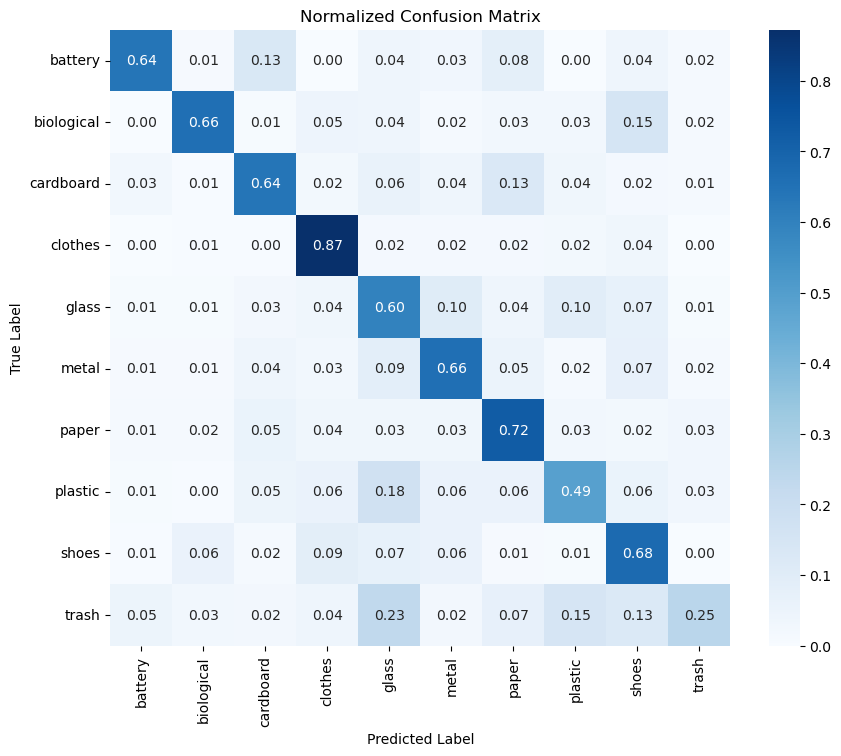

In [11]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# 클래스 이름 설정
class_names = ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
# 모델 평가 및 혼동 행렬 계산 함수
def evaluate_model_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)
    # 비율로 변환
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # 혼동 행렬 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()
# 검증 데이터셋에 대해 혼동 행렬 계산 및 시각화
evaluate_model_and_plot_confusion_matrix(model, dataloaders['val'], class_names)